In [49]:
# importing necessary libraries
import os 
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import sqlite3
import itertools

In [50]:
# loading and merging datasets (mls salaries from 2007-2017)
csv_paths=[files for files in os.listdir() if files[-4:]==".csv" and files[0:3]=="mls"]
mls_salaries=pd.concat(map(pd.read_csv,csv_paths))
mls_salaries.head()


,club,last_name,first_name,position,base_salary,guaranteed_compensation
0,CHI,Armas,Chris,M,225000.0,225000.0
1,CHI,Banner,Michael,M,12900.0,12900.0
2,CHI,Barrett,Chad,F,41212.5,48712.5
3,CHI,Blanco,Cuauhtemoc,F,2492316.0,2666778.0
4,CHI,Brown,C.J.,D,106391.0,106391.0


In [52]:
# generate years to add to the dataframe.
lengths=[]
for paths in csv_paths:
    lengths.append(len(pd.read_csv(paths)))
years=[year for year in range(2007,2018)]
add_years=np.repeat(years,[i for i in lengths])
mls_salaries["years"]=add_years
mls_salaries.head()

,club,last_name,first_name,position,base_salary,guaranteed_compensation,years
0,CHI,Armas,Chris,M,225000.0,225000.0,2007
1,CHI,Banner,Michael,M,12900.0,12900.0,2007
2,CHI,Barrett,Chad,F,41212.5,48712.5,2007
3,CHI,Blanco,Cuauhtemoc,F,2492316.0,2666778.0,2007
4,CHI,Brown,C.J.,D,106391.0,106391.0,2007


In [53]:
# checking dimensions of the datasets
print("length of rows= ",mls_salaries.shape[0])
print("length of columns = ",mls_salaries.shape[1])

length of rows=  5553
length of columns =  7


In [54]:
# excluding the first name and lastname columns
mls_salaries=mls_salaries.iloc[:,[0,3,4,5,6]]
mls_salaries.head()

,club,position,base_salary,guaranteed_compensation,years
0,CHI,M,225000.0,225000.0,2007
1,CHI,M,12900.0,12900.0,2007
2,CHI,F,41212.5,48712.5,2007
3,CHI,F,2492316.0,2666778.0,2007
4,CHI,D,106391.0,106391.0,2007


In [55]:
# check whether there are columns with na values
print(mls_salaries.isna().any())

club                        True
position                    True
base_salary                 True
guaranteed_compensation     True
years                      False
dtype: bool


In [56]:
# defining a function to reuses code  in replacing na with mean.
def replace_na_num(col): # numerical columns
    mean=col.mean()
    return col.fillna(value=mean,inplace=True)
replace_na_num(mls_salaries.base_salary) # replace na in base salary column
replace_na_num(mls_salaries.guaranteed_compensation)


    


In [57]:
# replace na in categorical columns with most frequent
def replace_na_cat(col):
    freq_dict={} # creating dictionary to add column as key and frequancy as value
    for vals in col:
        if vals in freq_dict:
            freq_dict[vals]+=1
        else:
            freq_dict[vals]=1
    return col.fillna(max(freq_dict,key=freq_dict.get),inplace=True)
replace_na_cat(mls_salaries.position)
replace_na_cat(mls_salaries.club)
print(mls_salaries.isna().any())

club                       False
position                   False
base_salary                False
guaranteed_compensation    False
years                      False
dtype: bool


In [58]:
# sort the dataframe based on salary from the highest paid to lowest
mls_salaries=mls_salaries.sort_values(by="base_salary",ascending=False)
print(mls_salaries.head())

    club position  base_salary  guaranteed_compensation  years
258  ORL        M    6660000.0                7167500.0   2015
401  ORL        M    6660000.0                7167500.0   2017
340  ORL        M    6660000.0                7167500.0   2016
268  ORL        M    6660000.0                7167500.0   2014
190   LA        M    6200004.0                6332504.0   2015


In [59]:
# adding the cleaned data to a databse
columns=mls_salaries.columns
command='create table if not exists mls'+ f"{*columns,}"
con=sqlite3.connect("mls_salaries.db")
con1=con.cursor()
con1.execute(command)
con.commit()
mls_salaries.to_sql('mls',con,if_exists='replace')

In [60]:
# group statistics
statistics=[sum,np.mean,np.std,min,max]
def grouped_stat(columns,statistics):
    agg_dict={
        "base_salary":statistics,
        "guaranteed_compensation":statistics
    }
    agg=mls_salaries.groupby(columns,sort=True).agg(
            agg_dict
        )
    return agg
# calclates total,standard deviation,maximum,minimum and average for salary and guranteed compensation in every year
year_group=grouped_stat(["years"],statistics)
year_group
#print(year_group)

base_salary                                                      \
                sum           mean            std       min         max   
years                                                                     
2007   3.847833e+07  103715.181752  333735.906611  12900.00  5500000.08   
2008   4.311883e+07  104912.003444  322165.897436  12900.00  5500000.08   
2009   4.689920e+07  120874.220438  335157.737515  15300.00  5500000.08   
2010   6.410895e+07  155982.837956  484146.524167  31250.04  5544000.00   
2011   7.499108e+07  142840.144057  423926.279495  32600.00  5500000.08   
2012   8.649280e+07  156124.184242  406138.705369  33750.00  5000000.00   
2013   8.480920e+07  147238.192969  368080.492018  35125.00  4913004.00   
2014   1.166924e+08  204007.701189  612750.320766  36500.00  6660000.00   
2015   1.517671e+08  264402.689826  728061.160945  50000.00  6660000.00   
2016   1.610863e+08  290245.664018  743851.502137  51492.00  6660000.00   
2017   1.829383e+08  296977.736867  671579.158073  52999.92  6660000.00   

      guaranteed_compensation                                          \
                          sum           mean            std       min   
years                                                                   
2007             4.222366e+07  113810.404501  385422.051903  12900.00   
2008             4.750251e+07  115577.885433  372908.772515  12900.00   
2009             5.187805e+07  133706.315696  385219.877285  15300.00   
2010             7.130497e+07  173491.417762  532641.064425  31260.00   
2011             8.507948e+07  162056.144400  474665.856104  32600.00   
2012             9.925788e+07  179165.850686  455820.838754  33750.00   
2013             9.507814e+07  165066.219271  399781.256554  35125.00   
2014             1.295318e+08  226454.264773  680465.546339  36500.00   
2015             1.675697e+08  291933.350226  800993.382063  50000.00   
2016             1.758114e+08  316777.328126  811876.906833  51492.00   
2017             2.009018e+08  326139.227695  748000.682339  52999.92   

                   
              max  
years              
2007   6500000.04  
2008   6500000.04  
2009   6500000.04  
2010   6500000.04  
2011   6500000.04  
2012   5600000.00  
2013   5038566.50  
2014   7167500.00  
2015   7167500.00  
2016   7167500.00  
2017   7167500.00

In [61]:
# summary statistics based on position of players
position_grouped=grouped_stat(["position"],statistics)
position_grouped
#print(position_grouped)

base_salary                                                     \
                   sum           mean            std       min        max   
position                                                                    
D         1.928911e+08  124045.721498  240063.320333   12900.0  5544000.0   
D-F       3.087000e+04   30870.000000            NaN   30870.0    30870.0   
D-M       8.322939e+06  106704.350385   75960.633280   20100.0   450000.0   
D/F       5.400000e+05  135000.000000   34156.502553  100000.0   180000.0   
D/M       9.975000e+05  124687.500000   74599.376434   50000.0   235000.0   
F         3.323721e+08  283593.957440  729290.455515   12900.0  6000000.0   
F-D       1.290000e+04   12900.000000            NaN   12900.0    12900.0   
F-M       8.945012e+06  208023.536744  243021.154595   15300.0   750000.0   
F/M       3.870065e+05   77401.300000   31567.082890   46500.0   125000.0   
GK        5.895635e+07   94785.129093  131778.698846   12900.0  2100000.0   
M         4.115190e+08  224873.755568  684505.559061   12900.0  6660000.0   
M-D       8.531223e+06  131249.585231  116115.261967   12900.0   625000.0   
M-F       2.337628e+07  178444.852061  195881.012729   12900.0  1400004.0   
M/D       6.937125e+05   69371.250000   33047.521576   44100.0   140000.0   
M/F       3.467096e+06  165099.809524  138775.451867   44000.0   550000.0   
MF        3.394880e+05   48498.285714    8955.943310   40000.0    60638.0   

         guaranteed_compensation                                          \
                             sum           mean            std       min   
position                                                                   
D                   2.098346e+08  134941.864887  245515.399386   12900.0   
D-F                 3.087000e+04   30870.000000            NaN   30870.0   
D-M                 9.239799e+06  118458.955256   85495.042868   20100.0   
D/F                 9.480000e+05  237000.000000   34156.502553  202000.0   
D/M                 1.034875e+06  129359.375000   78611.511945   52500.0   
F                   3.763667e+08  321131.982585  821751.856957   12900.0   
F-D                 1.290000e+04   12900.000000            NaN   12900.0   
F-M                 9.808646e+06  228108.045814  263263.207860   15300.0   
F/M                 5.332565e+05  106651.300000   21853.189920   81500.0   
GK                  6.376593e+07  102517.573446  157503.438727   12900.0   
M                   4.535900e+08  247863.399355  753024.723784   12900.0   
M-D                 9.535028e+06  146692.745385  125845.986165   12900.0   
M-F                 2.628280e+07  200632.051756  230482.636544   12900.0   
M/D                 7.912125e+05   79121.250000   40709.409765   44100.0   
M/F                 4.012929e+06  191091.872857  138552.594705   50000.0   
MF                  3.519074e+05   50272.482857    9965.005954   40000.0   

                      
                 max  
position              
D         5544000.00  
D-F         30870.00  
D-M        516667.07  
D/F        282000.00  
D/M        246625.00  
F         7115555.67  
F-D         12900.00  
F-M        820937.50  
F/M        131250.00  
GK        2575000.00  
M         7167500.00  
M-D        670000.00  
M-F       1788060.50  
M/D        161500.00  
M/F        565000.00  
MF          63527.80

In [62]:
# summary statistics for clubs spending
club_grouped=grouped_stat(["club"],statistics)
club_grouped
#print(club_grouped)

base_salary                                                     \
                sum           mean           std       min         max   
club                                                                     
ATL    8.212628e+06  241547.883529  3.625511e+05  51504.00  1912500.00   
CHI    5.544129e+07  181180.690229  4.343816e+05  12900.00  5400000.00   
CHV    2.059701e+07   88399.183433  8.965739e+04  12900.00  1000000.00   
CLB    3.831024e+07  123184.047685  1.479913e+05  12900.00  1175000.00   
COL    4.096501e+07  133003.278377  2.313637e+05  12900.00  2100000.00   
DAL    4.132608e+07  120836.480848  1.524571e+05  12900.00  1863996.00   
DC     3.823194e+07  123727.956408  1.400793e+05  12900.00  1500000.00   
HOU    3.763696e+07  128453.776416  1.189788e+05  12900.00   750000.00   
KC     4.076303e+07  134088.919145  1.541876e+05  12900.00   850000.00   
LA     1.245875e+08  395515.901619  1.070755e+06  12900.00  6200004.00   
LAFC   1.180080e+05   59004.000000  8.485281e+03  53004.00    65004.00   
MNUFC  4.926046e+06  182446.149630  1.199222e+05  53004.00   550008.00   
MTL    2.927659e+07  167294.808800  2.413262e+05  33750.00  1666668.00   
NE     4.025448e+07  136920.007075  2.664412e+05  12900.00  3000000.00   
NY     7.752091e+07  304003.564549  8.951468e+05  12900.00  5544000.00   
NYCFC  5.535537e+07  629038.332500  1.537016e+06  48504.00  6000000.00   
NYRB   1.150073e+07  209104.148182  2.447540e+05  51500.00  1500000.00   
None   2.927100e+05   97570.000000  1.949448e+04  84710.00   120000.00   
ORL    4.028191e+07  428530.944681  1.329319e+06  36500.00  6660000.00   
PHI    3.231505e+07  144910.538655  1.500063e+05  32604.00  1131000.00   
POOL   4.568600e+05   41532.730909  8.643045e+03  33750.00    62500.00   
POR    3.641583e+07  179388.331823  2.652437e+05  32600.04  2227500.00   
Pool   4.864000e+05   27022.222222  9.886625e+03  12900.00    40000.00   
RSL    3.835814e+07  128288.078395  1.601006e+05  12900.00  1750000.00   
SEA    6.239463e+07  236343.312066  6.163025e+05  15300.00  4913004.00   
SJ     3.674646e+07  131707.730251  1.425416e+05  12900.00   988000.00   
TFC    1.884275e+07  142748.125985  2.589912e+05  12900.00  1863996.00   
TOR    8.424767e+07  501474.234048  1.368866e+06  33750.00  6000000.00   
VAN    3.552032e+07  170770.782596  2.280177e+05  32600.00  1400000.04   

      guaranteed_compensation                                         \
                          sum           mean           std       min   
club                                                                   
ATL              9.184770e+06  270140.301765  4.284820e+05  51504.00   
CHI              6.050692e+07  197735.024967  4.528251e+05  12900.00   
CHV              2.258553e+07   96933.611888  1.084714e+05  12900.00   
CLB              4.266524e+07  137187.276463  1.600354e+05  12900.00   
COL              4.509238e+07  146403.828149  2.648081e+05  12900.00   
DAL              4.677233e+07  136761.189298  1.668507e+05  12900.00   
DC               4.320290e+07  139815.201618  1.649559e+05  12900.00   
HOU              4.078001e+07  139180.906792  1.286232e+05  12900.00   
KC               4.427850e+07  145652.967961  1.641157e+05  12900.00   
LA               1.412526e+08  448420.975111  1.232536e+06  12900.00   
LAFC             1.180080e+05   59004.000000  8.485281e+03  53004.00   
MNUFC            5.322865e+06  197143.131481  1.281125e+05  53004.00   
MTL              3.538674e+07  202209.959200  3.603423e+05  33750.00   
NE               4.428478e+07  150628.492687  2.870699e+05  12900.00   
NY               8.409992e+07  329803.624000  9.616583e+05  12900.00   
NYCFC            5.693658e+07  647006.600909  1.562379e+06  48504.00   
NYRB             1.272504e+07  231364.299818  2.696241e+05  51500.00   
None             3.017100e+05  100570.000000  2.467599e+04  84710.00   
ORL              4.348296e+07  462584.703617  1.430376e+06  44000.00   
PHI              3.604160e+07  161621.545516  1.615132e

In [63]:
# clubs spending on salary and compensation summary every year
club_years=grouped_stat(["years","club"],statistics)
# deposit the large dataframe to a csv file
club_years.to_csv("club_years_agg.csv")
club_years
#print(club_years)

base_salary                                                     \
                    sum           mean           std       min         max   
years club                                                                   
2007  CHI    4412517.50  152155.775862  4.544541e+05  12900.00  2492316.00   
      CHV    1678270.70   59938.239286  5.003792e+04  12900.00   245000.00   
      CLB    1889551.06   65156.933103  4.826129e+04  12900.00   165000.00   
      COL    2181153.00   75212.172414  6.884605e+04  12900.00   280000.00   
      DAL    2790739.75   90023.862903  1.594678e+05  12900.00   872736.00   
...                 ...            ...           ...       ...         ...   
2017  RSL    6856440.44  253942.238519  3.567245e+05  53004.00  1750000.00   
      SEA    8986702.89  359468.115600  6.738791e+05  52999.92  3200000.00   
      SJ     6429566.00  221709.172414  1.970260e+05  53004.00   800000.00   
      TOR   20074947.00  743516.555556  1.722059e+06  53004.00  6000000.00   
      VAN    7040366.08  220011.440000  2.721918e+05  54075.00  1400000.04   

           guaranteed_compensation                                         \
                               sum           mean           std       min   
years club                                                                  
2007  CHI               4716304.50  162631.189655  4.862896e+05  12900.00   
      CHV               1789645.70   63915.917857  5.170747e+04  12900.00   
      CLB               2108226.06   72697.450345  5.283872e+04  12900.00   
      COL               2281303.00   78665.620690  7.099328e+04  12900.00   
      DAL               3072764.75   99121.443548  1.661547e+05  12900.00   
...                            ...            ...           ...       ...   
2017  RSL               7419355.44  274790.942222  4.001259e+05  53004.00   
      SEA              10306150.48  412246.019200  8.213079e+05  52999.92   
      SJ                6959287.11  239975.417586  2.040377e+05  53004.00   
      TOR              22399815.27  829622.787778  1.952724e+06  53004.00   
      VAN               8079371.07  252480.345938  3.422447e+05  54075.00   

                        
                   max  
years club              
2007  CHI   2666778.00  
      CHV    248750.00  
      CLB    188000.00  
      COL    298000.00  
      DAL    879936.00  
...                ...  
2017  RSL   1973750.00  
      SEA   3892933.50  
      SJ     800000.00  
      TOR   7115555.67  
      VAN   1800000.04  

[213 rows x 10 columns]

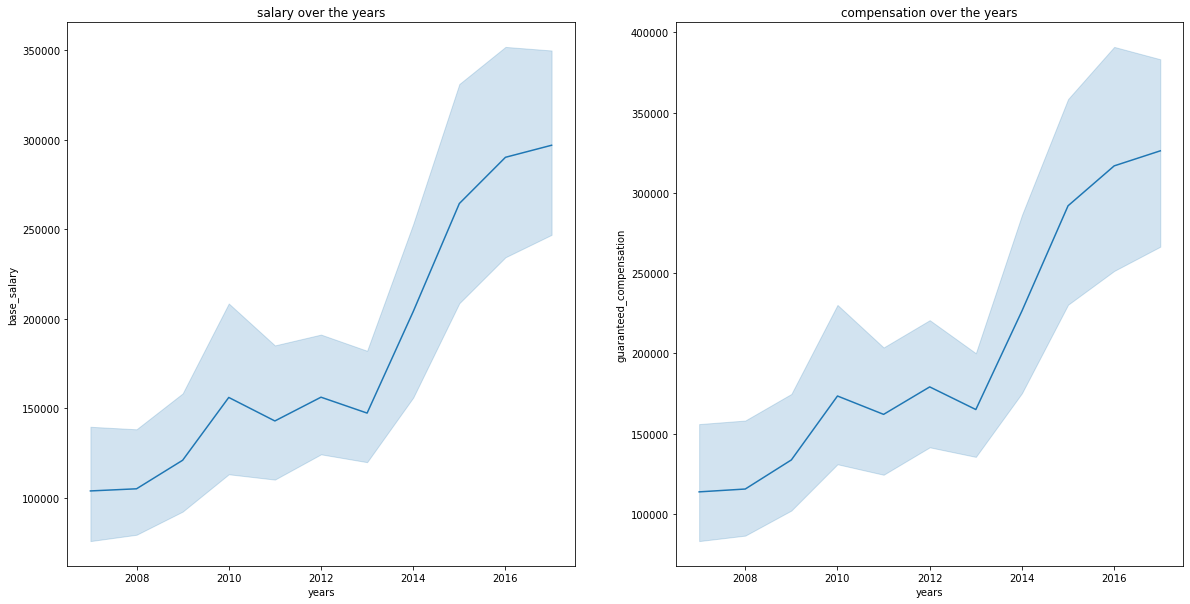

In [64]:
# changes in salary and compensation over the years
fig,ax=plt.subplots(1,2,figsize=(20,10))
sn.lineplot(ax=ax[0],x="years",y="base_salary",data=mls_salaries)
ax[0].set_title("salary over the years")
sn.lineplot(ax=ax[1],x="years",y="guaranteed_compensation",data=mls_salaries)
ax[1].set_title("compensation over the years")
plt.show()


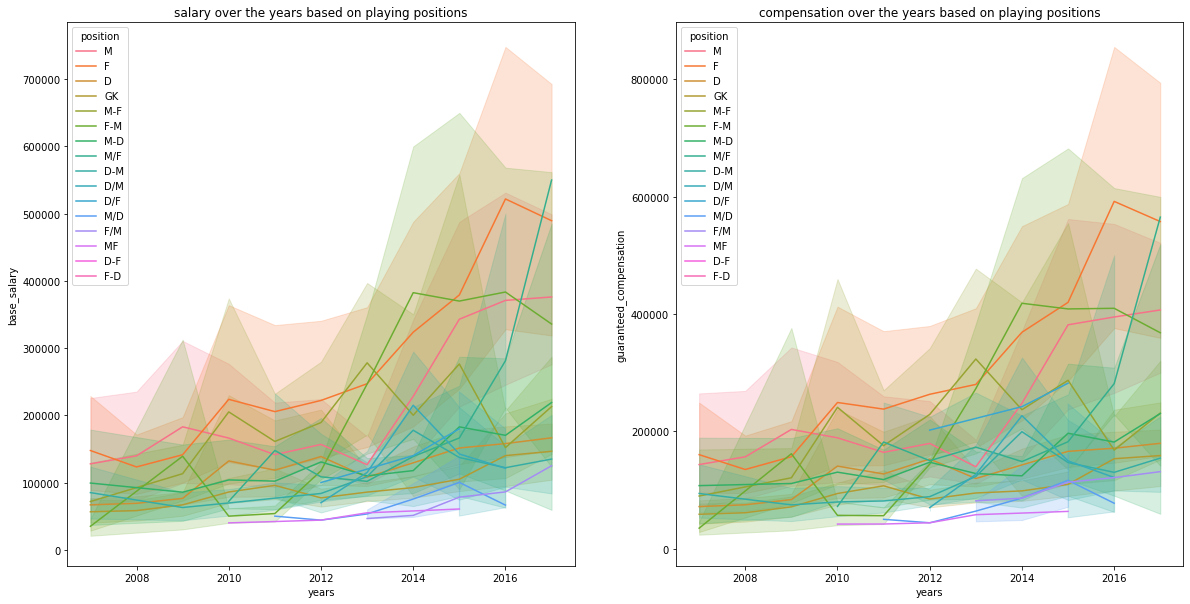

In [65]:
#  salary and compensation over the years on basis of playing position
fig,ax=plt.subplots(1,2,figsize=(20,10))
sn.lineplot(ax=ax[0],x="years",y="base_salary",hue="position",data=mls_salaries)
ax[0].set_title("salary over the years based on playing positions")
sn.lineplot(ax=ax[1],x="years",y="guaranteed_compensation",hue="position",data=mls_salaries)
ax[1].set_title("compensation over the years based on playing positions")
plt.show()

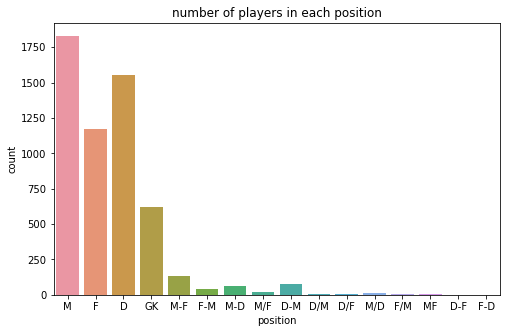

In [137]:
# visualising number of players in each position
fig=plt.figure(figsize=(8,5))
sn.countplot(x="position",data=mls_salaries)
plt.title("number of players in each position")
plt.show()

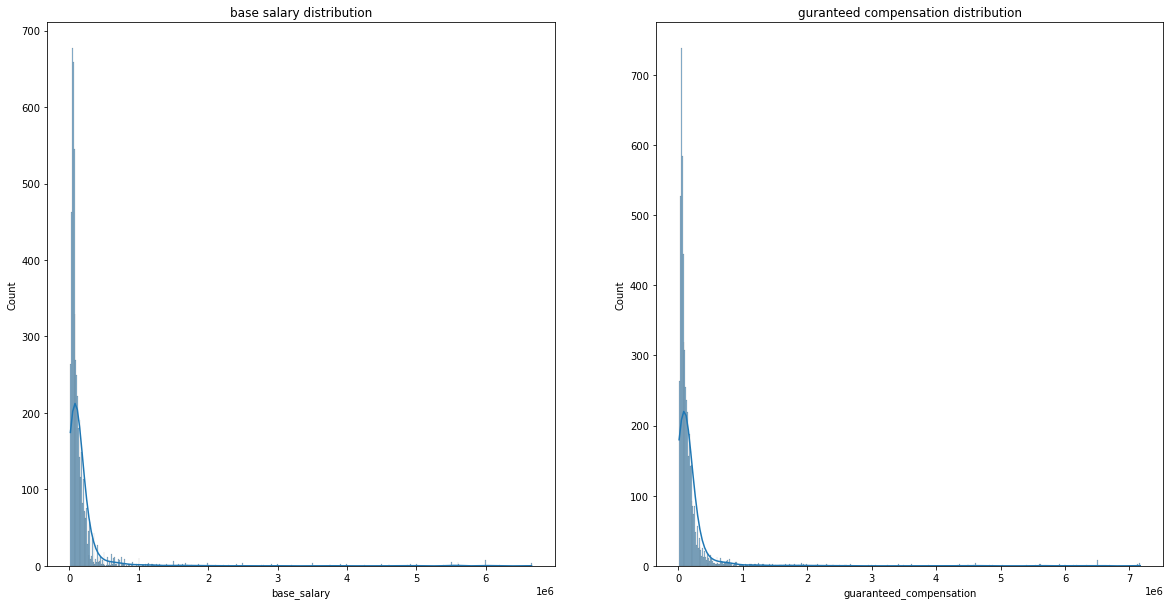

In [20]:
# distribution of salaries ang guranteed compensations 
fig,ax=plt.subplots(1,2,figsize=(20,10))
sn.histplot(ax=ax[0],x="base_salary",data=mls_salaries,kde=True)
ax[0].set_title("base salary distribution")
sn.histplot(ax=ax[1],x="guaranteed_compensation",data=mls_salaries,kde=True)
ax[1].set_title("guranteed compensation distribution")
plt.show()


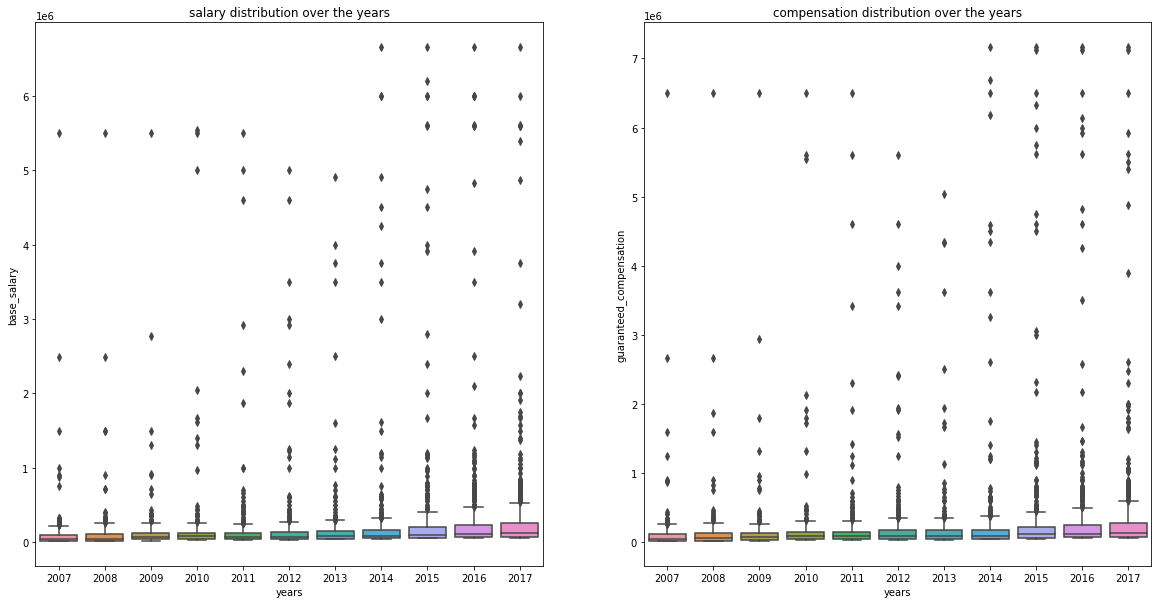

In [43]:
# salary and compensation distribution over the years
fig,ax=plt.subplots(1,2,figsize=(20,10))
sn.boxplot(ax=ax[0],x="years",y="base_salary",data=mls_salaries)
ax[0].set_title("salary distribution over the years")
sn.boxplot(ax=ax[1],x="years",y="guaranteed_compensation",data=mls_salaries)
ax[1].set_title("compensation distribution over the years")
plt.show()

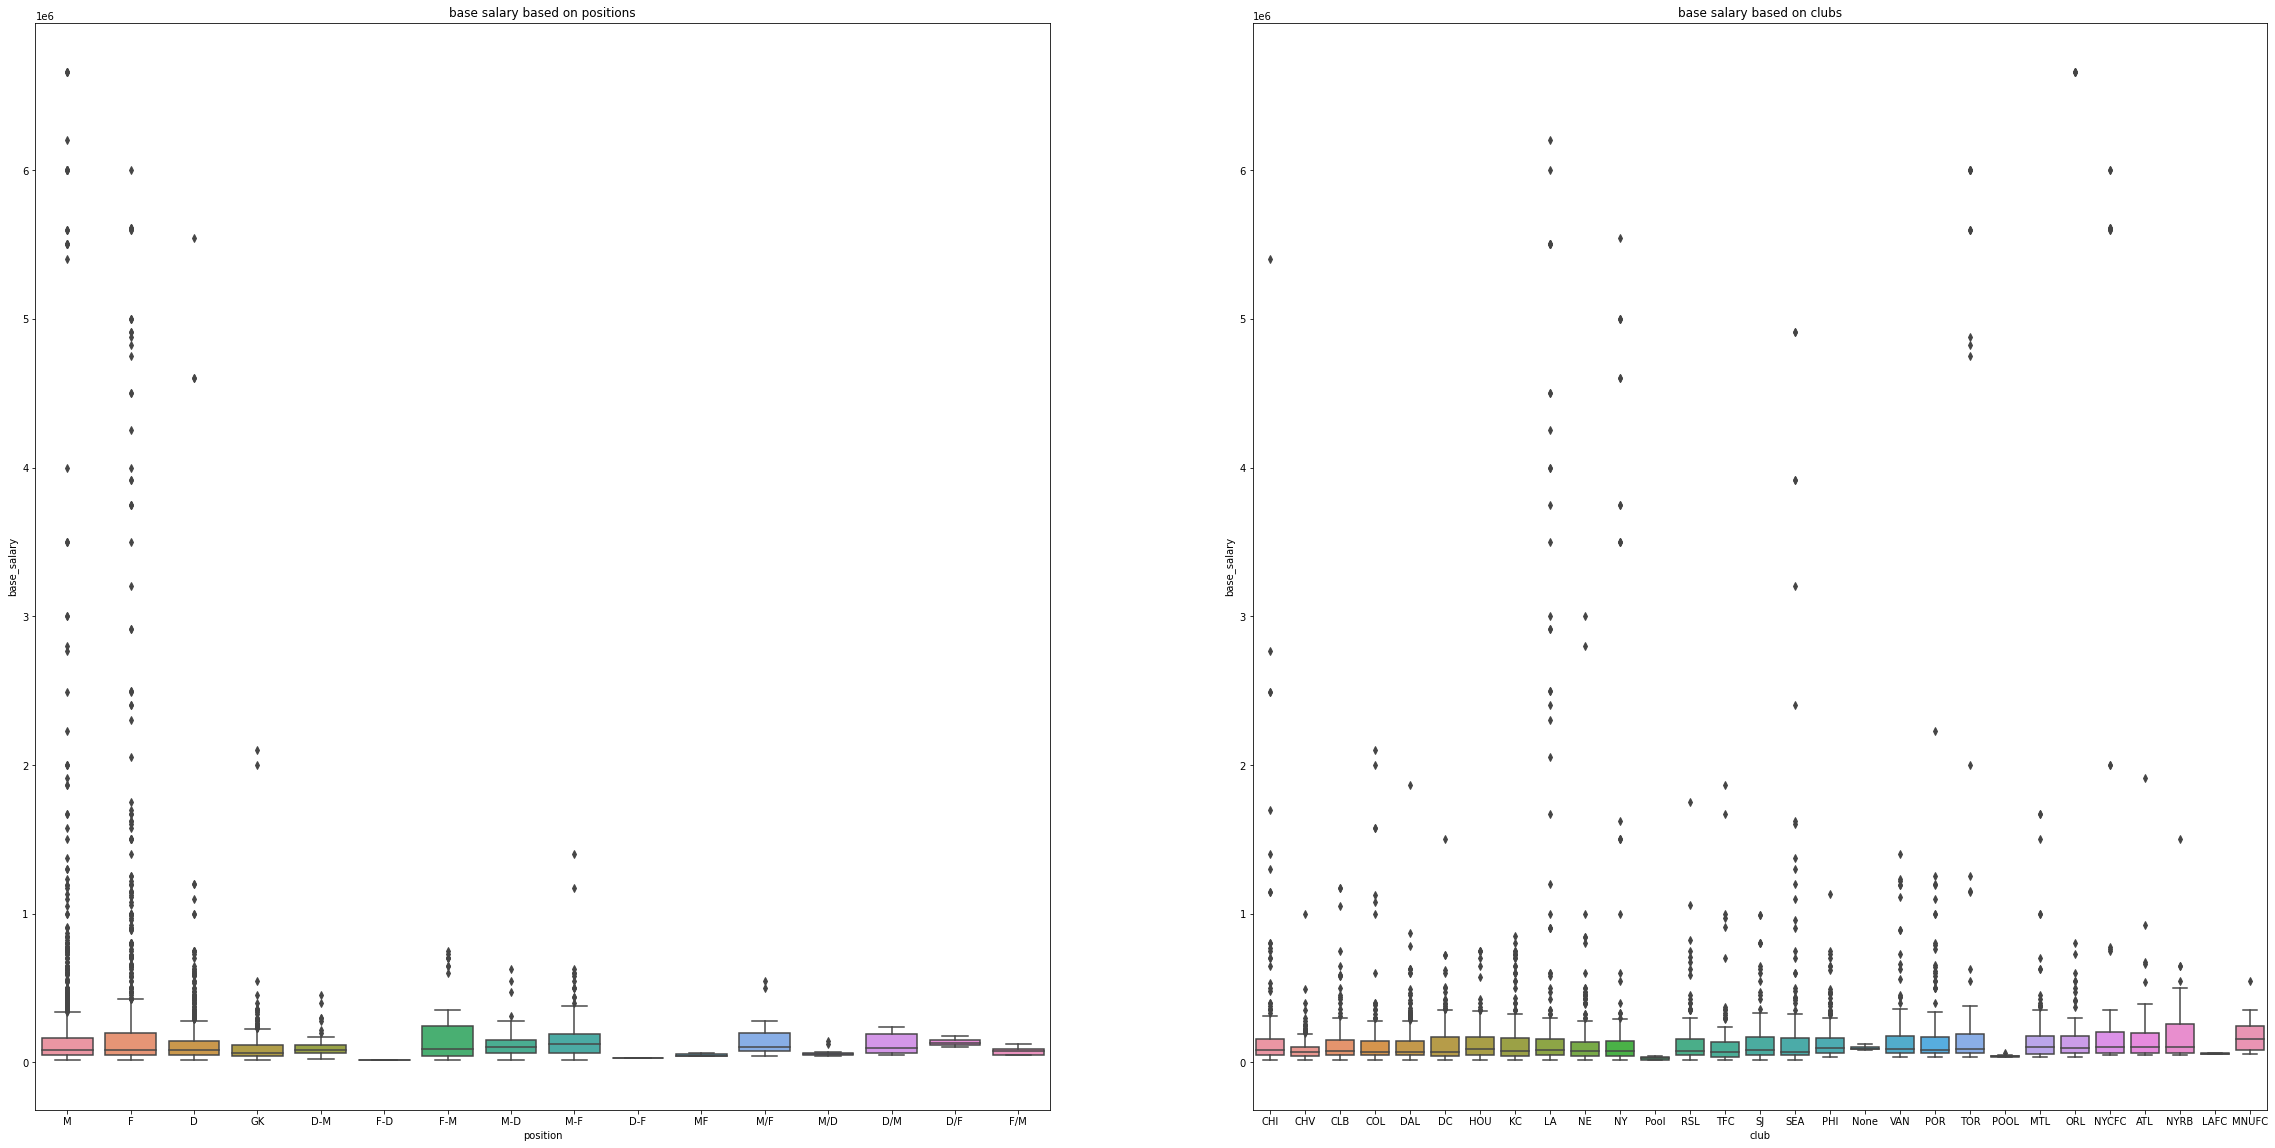

In [31]:
# compare distribution of salaries based on positions and clubs
# also detecting outliers
fig,ax=plt.subplots(1,2,figsize=(40,20))
sn.boxplot(ax=ax[0],x="position",y="base_salary",data=mls_salaries)
ax[0].set_title("base salary distribution based on positions")
sn.boxplot(ax=ax[1],x="club",y="base_salary",data=mls_salaries)
ax[1].set_title("base salary distribution based on clubs")
plt.show()


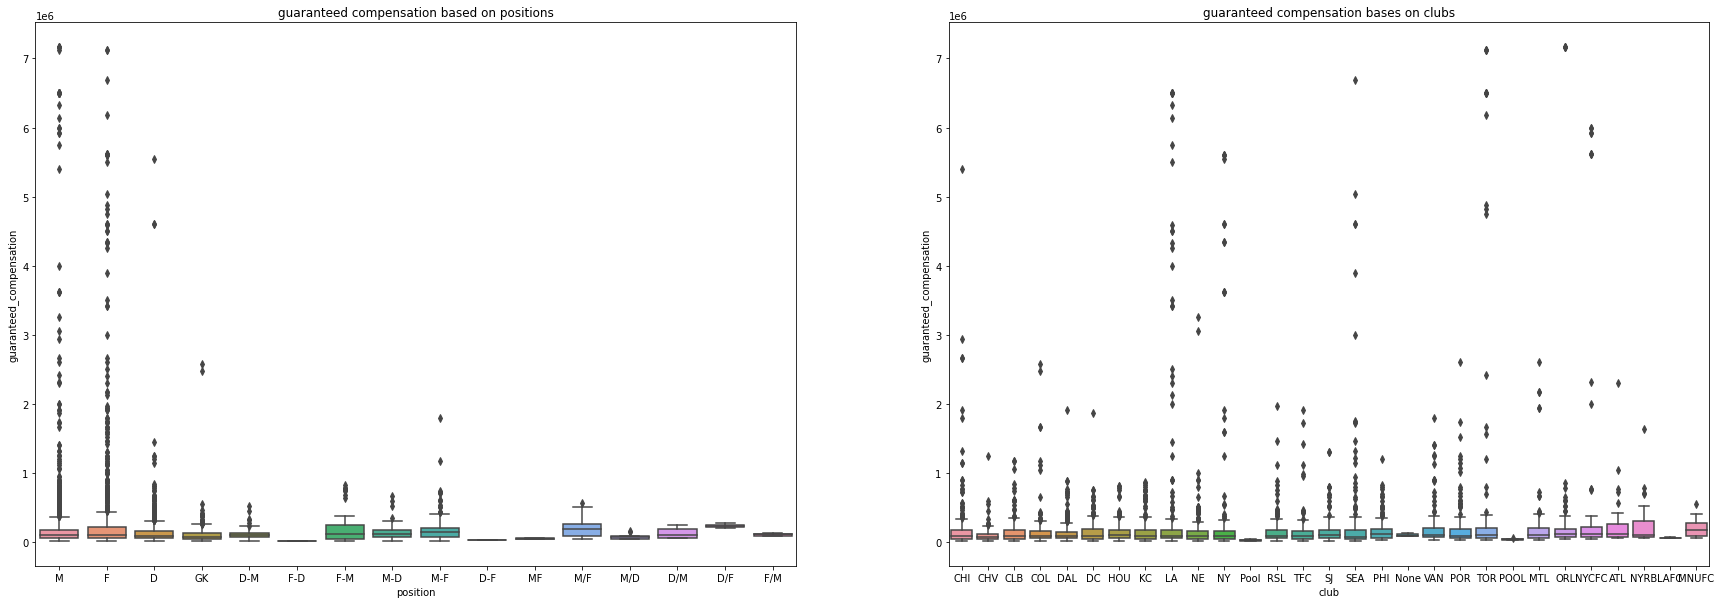

In [32]:
# comparing compensations based on positions and clubs
fig,ax=plt.subplots(1,2,figsize=(30,10))
sn.boxplot(ax=ax[0],x="position",y="guaranteed_compensation",data=mls_salaries)
ax[0].set_title("guaranteed compensation based on positions")
sn.boxplot(ax=ax[1],x="club",y="guaranteed_compensation",data=mls_salaries)
ax[1].set_title("guaranteed compensation bases on clubs")
plt.show()

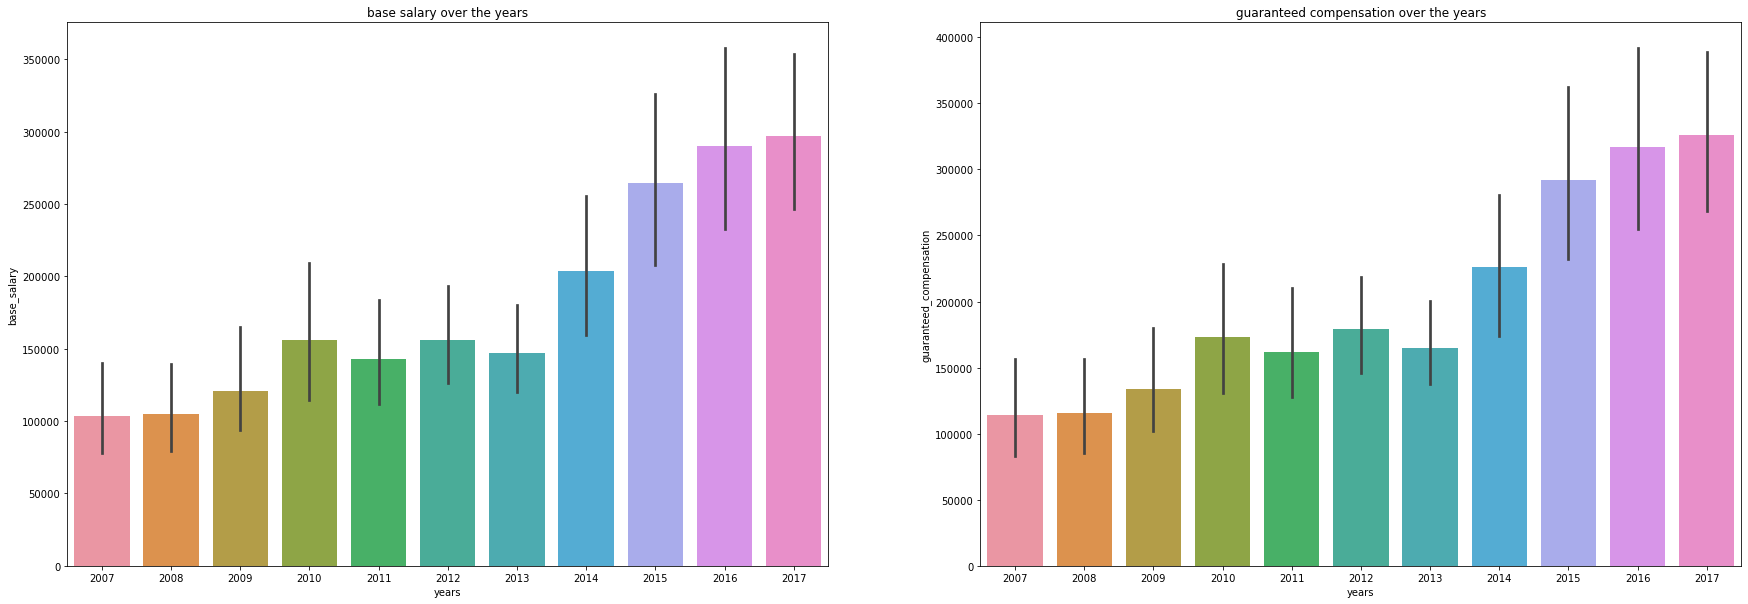

In [66]:
# years with highest salaries and compensation
fig,ax=plt.subplots(1,2,figsize=(30,10))
sn.barplot(ax=ax[0],x="years",y="base_salary",data=mls_salaries)
ax[0].set_title("base salary over the years")
sn.barplot(ax=ax[1],x="years",y="guaranteed_compensation",data=mls_salaries)
ax[1].set_title("guaranteed compensation over the years")
plt.show()


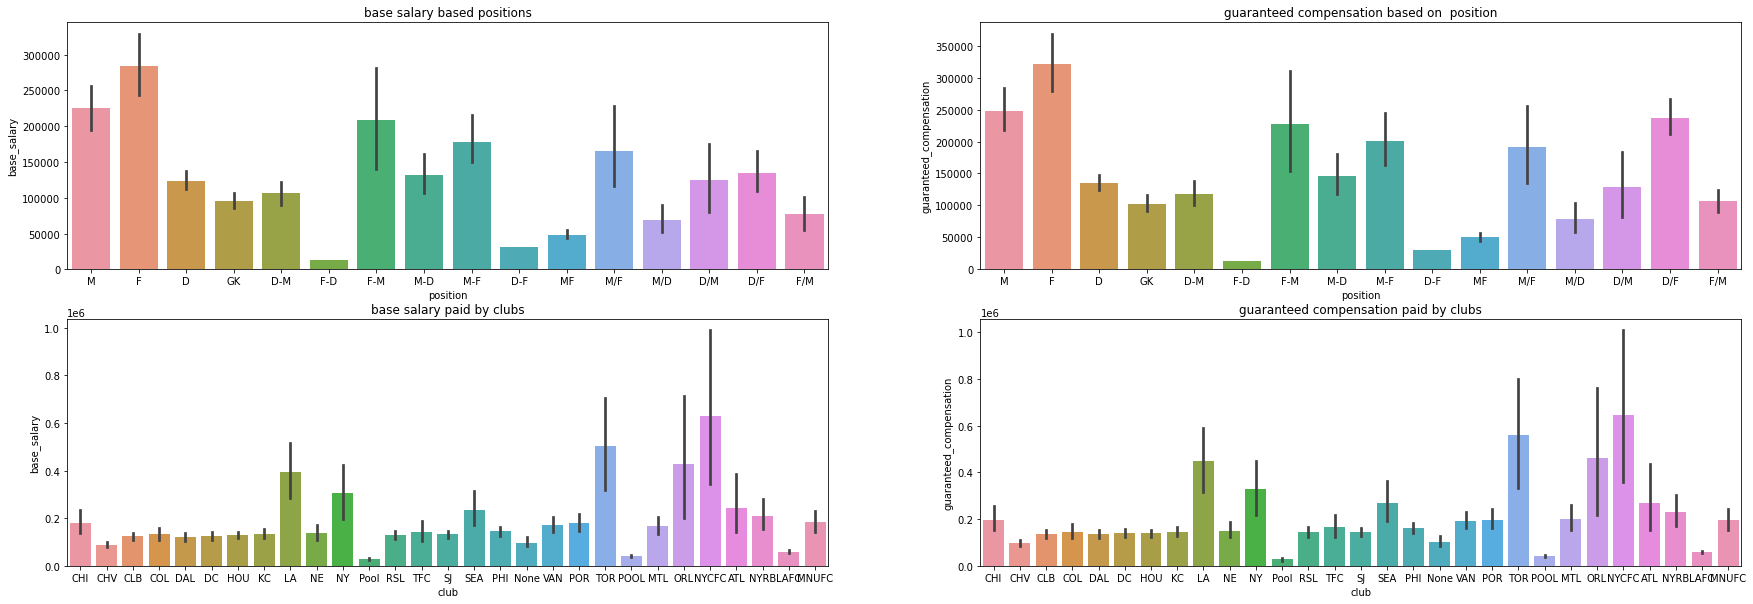

In [38]:
#barplots
# comparing salary and compensations paid by clubs
#comparing salary and compensations received in terms of positions
fig,ax=plt.subplots(2,2,figsize=(30,10))
sn.barplot(ax=ax[0,0],x="position",y="base_salary",data=mls_salaries)
ax[0,0].set_title("base salary based positions")
sn.barplot(ax=ax[0,1],x="position",y="guaranteed_compensation",data=mls_salaries)
ax[0,1].set_title("guaranteed compensation based on  position")
sn.barplot(ax=ax[1,0],x="club",y="base_salary",data=mls_salaries)
ax[1,0].set_title("base salary paid by clubs")
sn.barplot(ax=ax[1,1],x="club",y="guaranteed_compensation",data=mls_salaries)
ax[1,1].set_title("guaranteed compensation paid by clubs")
plt.show()

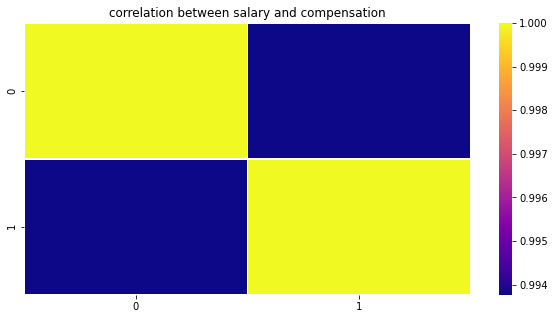

In [70]:
# display correlation between salary and compensation
fig=plt.figure(figsize=(10,5))
sn.heatmap(np.corrcoef(mls_salaries.base_salary,mls_salaries.guaranteed_compensation),linewidth=0.5,cmap="plasma")
plt.title("correlation between salary and compensation")
plt.show()

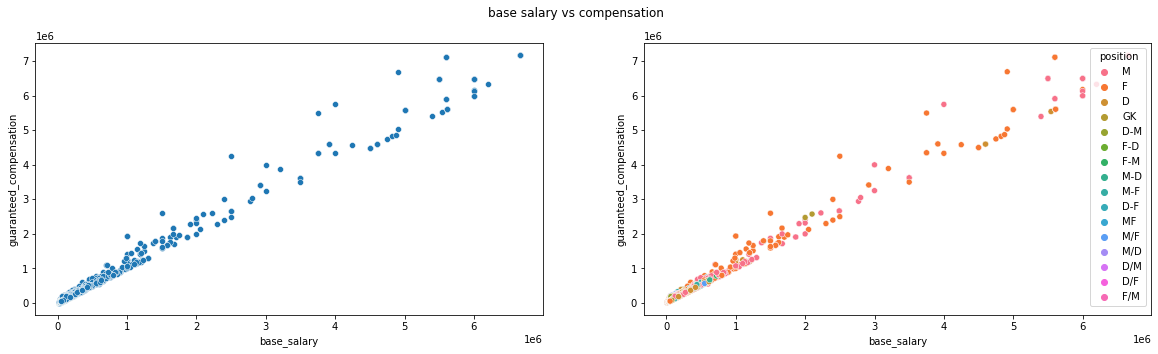

In [83]:
# investigating relationship between salary and compensation
fig,(ax,axs)=plt.subplots(1,2,figsize=(20,5))
fig.suptitle("base salary vs compensation")
sn.scatterplot(x="base_salary",y="guaranteed_compensation",data=mls_salaries,ax=ax)
sn.scatterplot(x="base_salary",y="guaranteed_compensation",hue="position",data=mls_salaries,ax=axs)
plt.show()

<Figure size 1440x720 with 0 Axes>

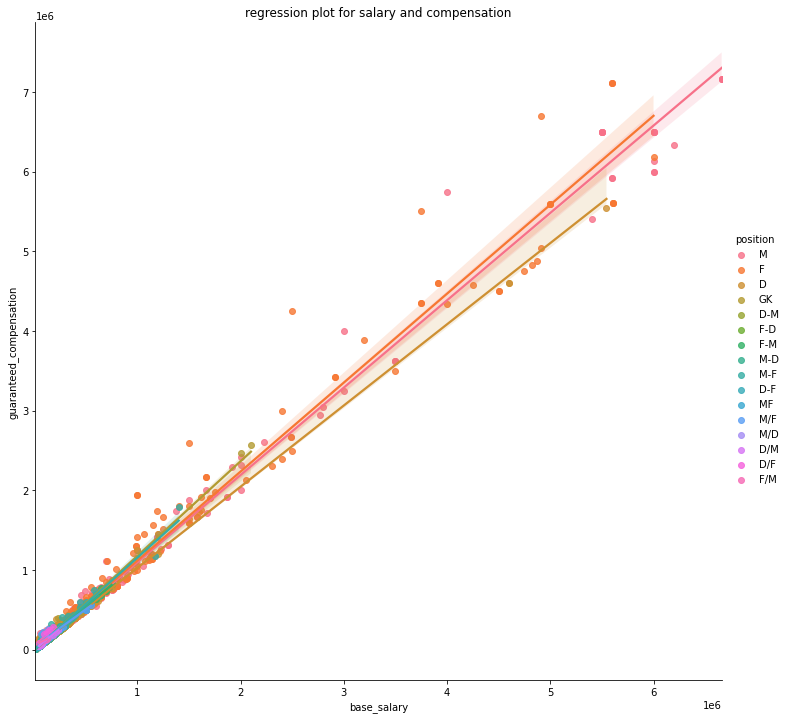

In [89]:
#regression plot for base salary and guaranteed compensation based on positions
fig=plt.figure(figsize=(20,10))
sn.lmplot(x="base_salary",y="guaranteed_compensation",hue="position",data=mls_salaries,height=10)
plt.title("regression plot for salary and compensation")
plt.show()

<Figure size 1440x720 with 0 Axes>

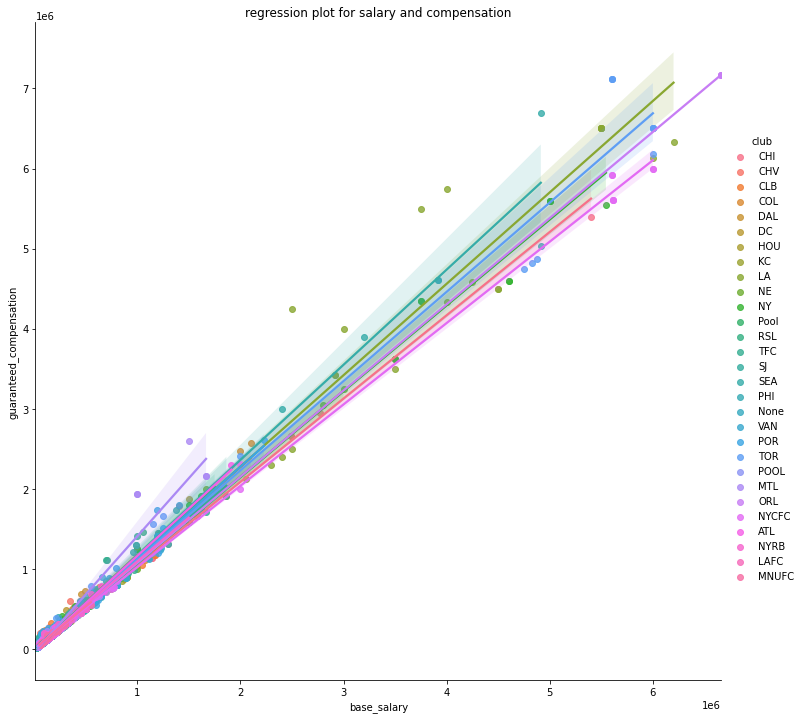

In [88]:
#regression plot for base salary and guaranteed compensation in terms of clubs
fig=plt.figure(figsize=(20,10))
sn.lmplot(x="base_salary",y="guaranteed_compensation",hue="club",data=mls_salaries,height=10)
plt.title("regression plot for salary and compensation")
plt.show()



<Figure size 720x720 with 0 Axes>

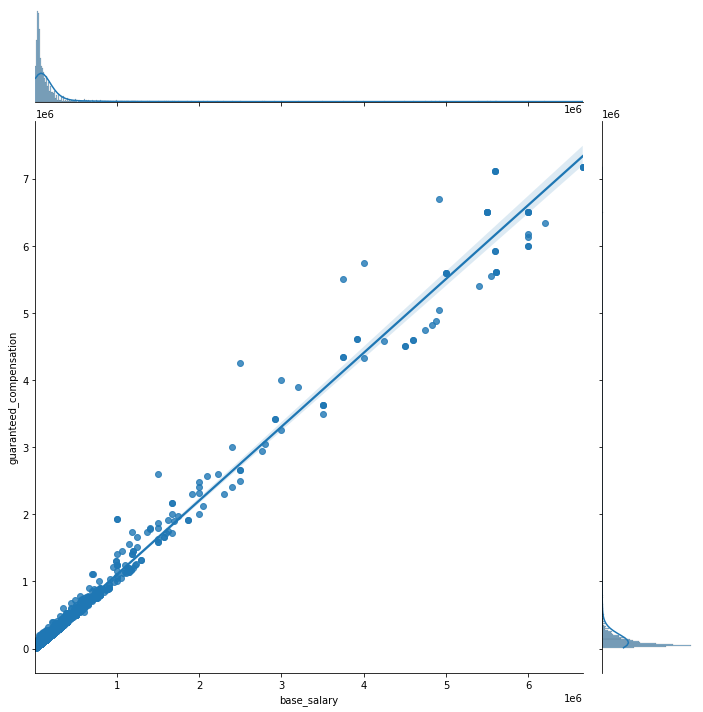

In [90]:
# showing distribution and regression
fig=plt.figure(figsize=(10,10))
sn.jointplot(x="base_salary",y="guaranteed_compensation",data=mls_salaries,kind="reg",height=10)
plt.show()